In [1]:
from Scripts import (
    prices,
    alvos,
    features,
    result_predict,
    split_data,
    machines,
    graphs
)
from pandas import concat

def print_dict(data):
    for key, value in data.items():
        print(f"\n[ {key.upper()} ]")
        for metric, val in value.items():
            if metric == "confusion_matrix":
                print(f"  {metric}:")
                for row in val:
                    print(f"    {row}")
            else:
                print(f"  {metric}: {val:.3f}")

def print_dict2(data, _):
    string = ''
    for key, value in data.items():
        if key == 'train':
            string += (f'( {_} )')
            
        string += f"\n[ {key.upper()} ]"
        for metric, val in value.items():
            if metric == "confusion_matrix":
                string += f"  {metric}:"
                for row in val:
                    string += f"    {row}"
            else:
                string += f"  {metric}: {val:.3f}"
    print(string+'\n')



In [2]:
ticker = 'BBDC4.SA'
start = '2012-05-11'
end = '2022-05-11'
__features__ = [0]
contratos = 100

def _rswsx(__0__, ot = None, _ = 1):

    df = prices.Prices.get(ticker)

    df = alvos.Alvos(df, p=1).A_BINARIO
    df[f'__{__features__[0]}__'] = __0__(df)

    sd = split_data.SplitData(df, start, end, step_size=None)
    train = sd.train()
    test = sd.test()
    after_test = sd.after_test()

    len_init = len(train) + len(test) + len(after_test)

    ml = machines.Machines(train, test, after_test, __features__)
    model = ml.train_decision_tree()
    train = ml.predict_train(model)
    test = ml.predict_test(model)
    after_test = ml.predict_after_test(model)

    rp = result_predict.ResultPredict(train, test, after_test, lotes=contratos)
    train = rp.calcula_train_day()
    test = rp.calcula_test_day()
    after_test = rp.calcula_after_test_day()

    df = concat([train, test, after_test], axis=0)
    df['resultado_predicao_acumulado'] = df['resultado_predicao'].cumsum()

    if ot is None:
        print('Dados perdidos: ', len_init - len(df.dropna()))
        print_dict(ml.evaluate())
        print('NaN: ', df['__0__'].isnull().sum())

        graphs.Graphs(df, f'__0__', (15, 4), 1, ylabel='Variação', title=f"Série Temporal - Feature '__0__' ").linha()
        graphs.Graphs(df, ['Adj Close', f'__0__'], (15, 4)).correlacao()
        graphs.Graphs(df, 'resultado_predicao_acumulado', (15, 5), 1, ylabel='Patrimônio Acumulado (Reais)', title='Train, Test and After Test', seta=True).linha()
        graphs.Graphs(df, 'resultado_predicao_acumulado', (15, 5), 1, ylabel='Retorno Anual (Reais)', title='Train, Test and After Test').barplot()
        graphs.Graphs(df[['predicao']], 'predicao', (3, 3), xlabel='', title=f"Distribuição da Predição (After Test)",
                    fontsize_title=14, tick_params_labelsize=2).pio()
    else:
        print_dict2(ml.evaluate(), _=_)
    

Dados perdidos:  0

[ TRAIN ]
  accuracy: 0.511
  precision: 0.743
  recall: 0.042
  f1_score: 0.079
  confusion_matrix:
    [608, 9]
    [597, 26]

[ TEST ]
  accuracy: 0.522
  precision: 0.471
  recall: 0.208
  f1_score: 0.288
  confusion_matrix:
    [527, 135]
    [458, 120]

[ AFTER_TEST ]
  accuracy: 0.515
  precision: 0.404
  recall: 0.063
  f1_score: 0.109
  confusion_matrix:
    [310, 28]
    [282, 19]
NaN:  0


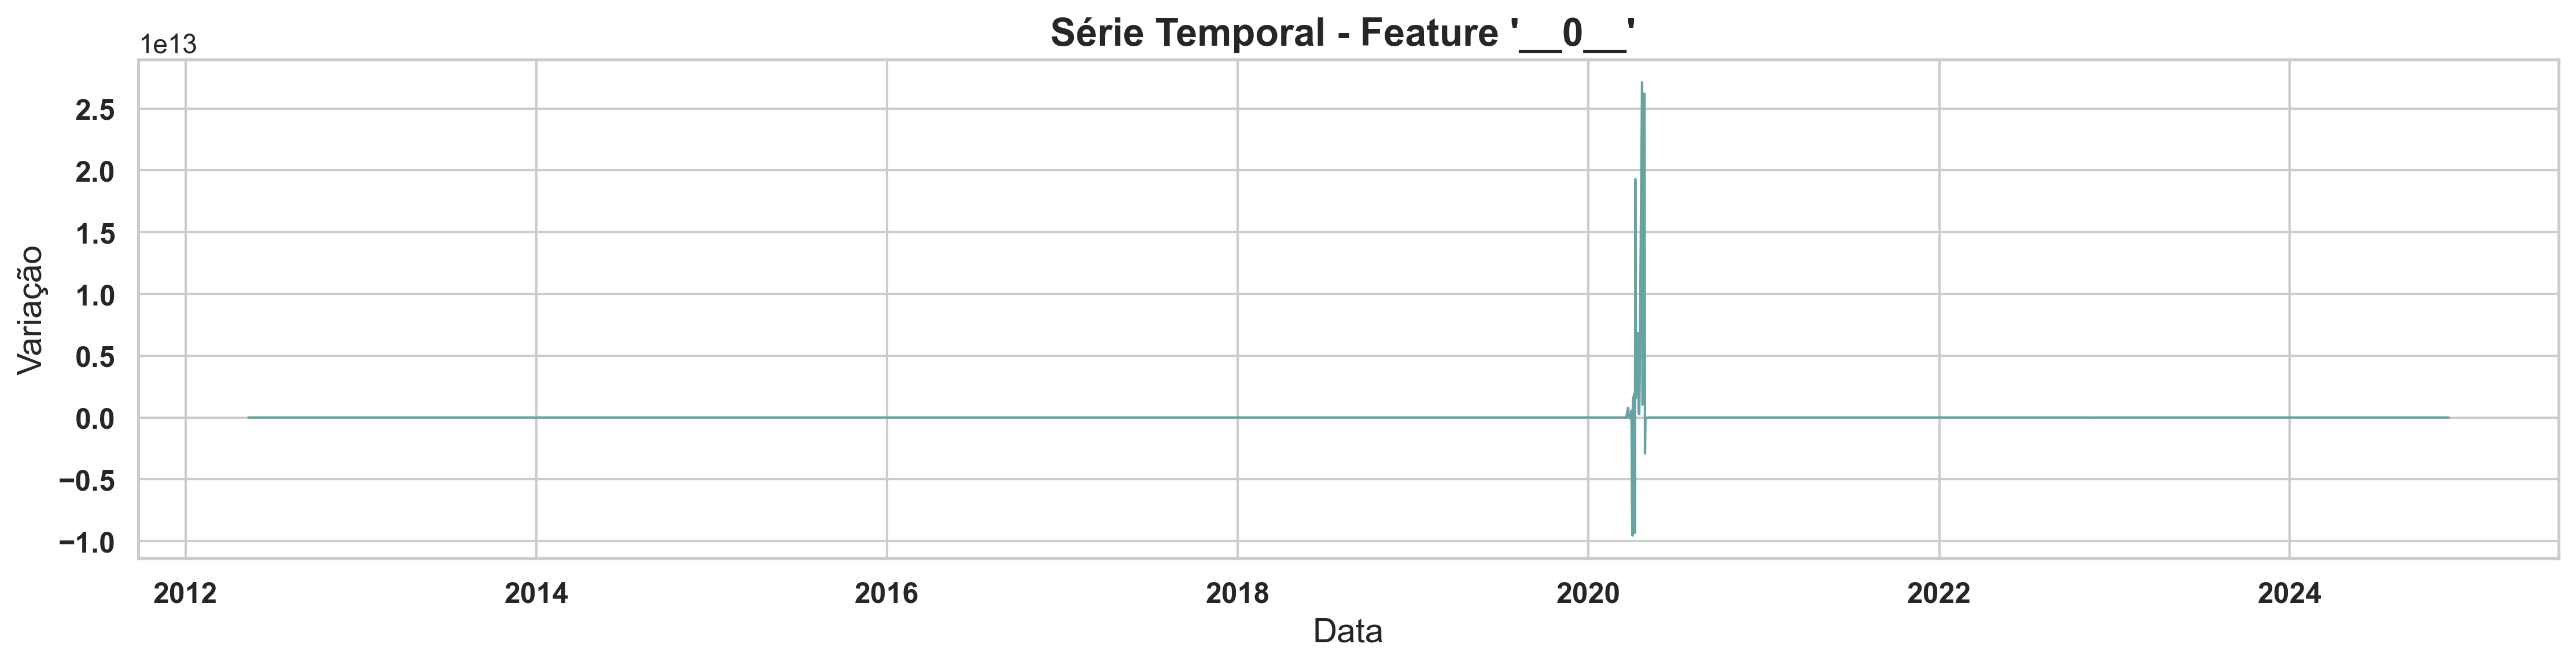

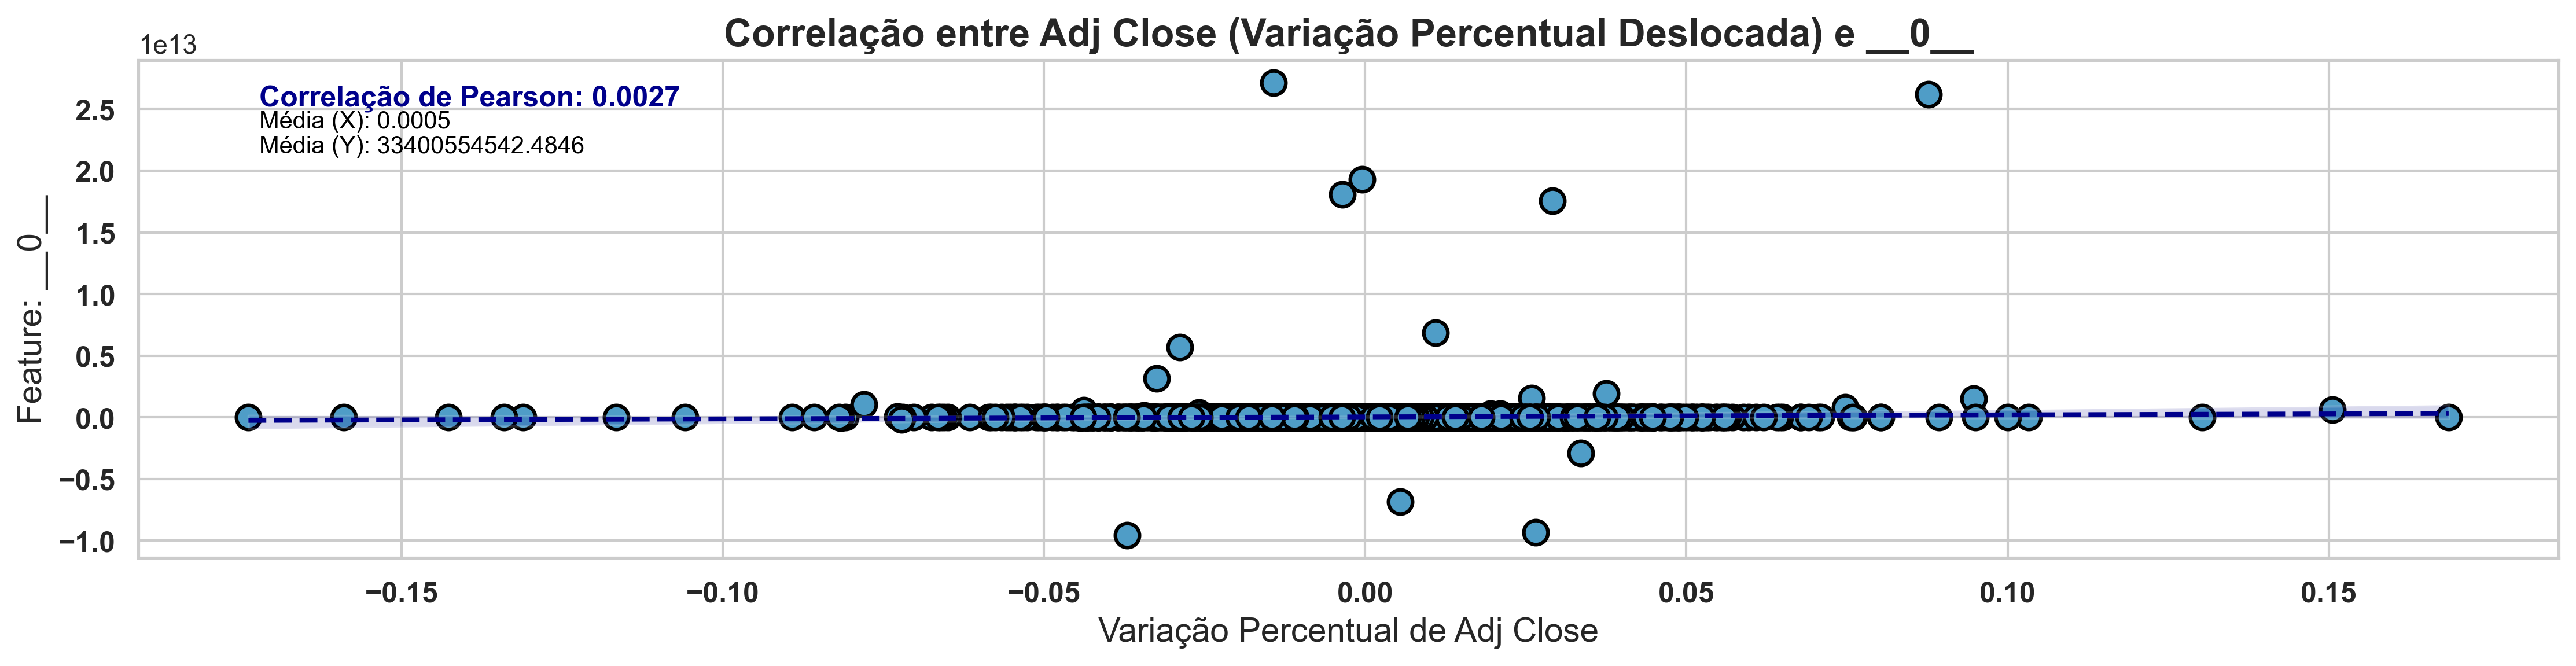

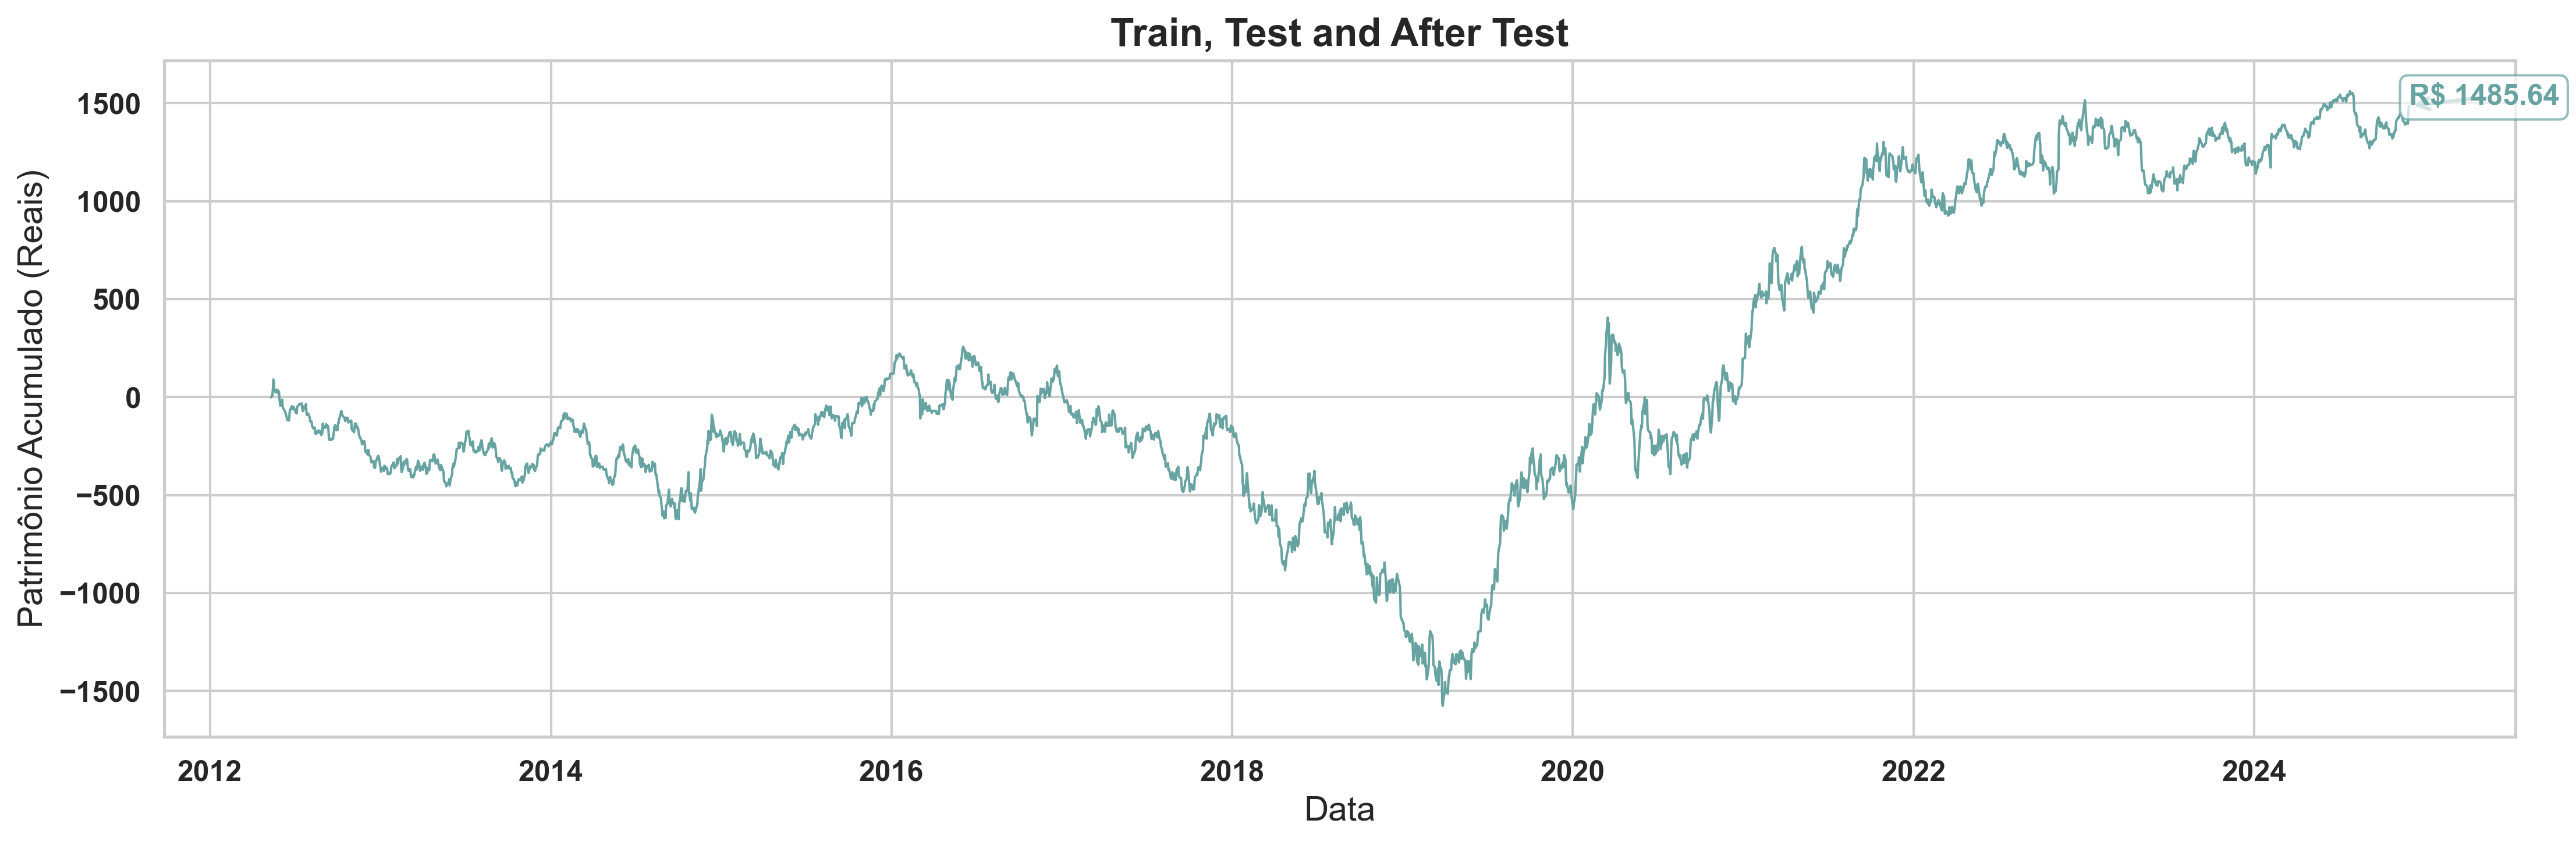

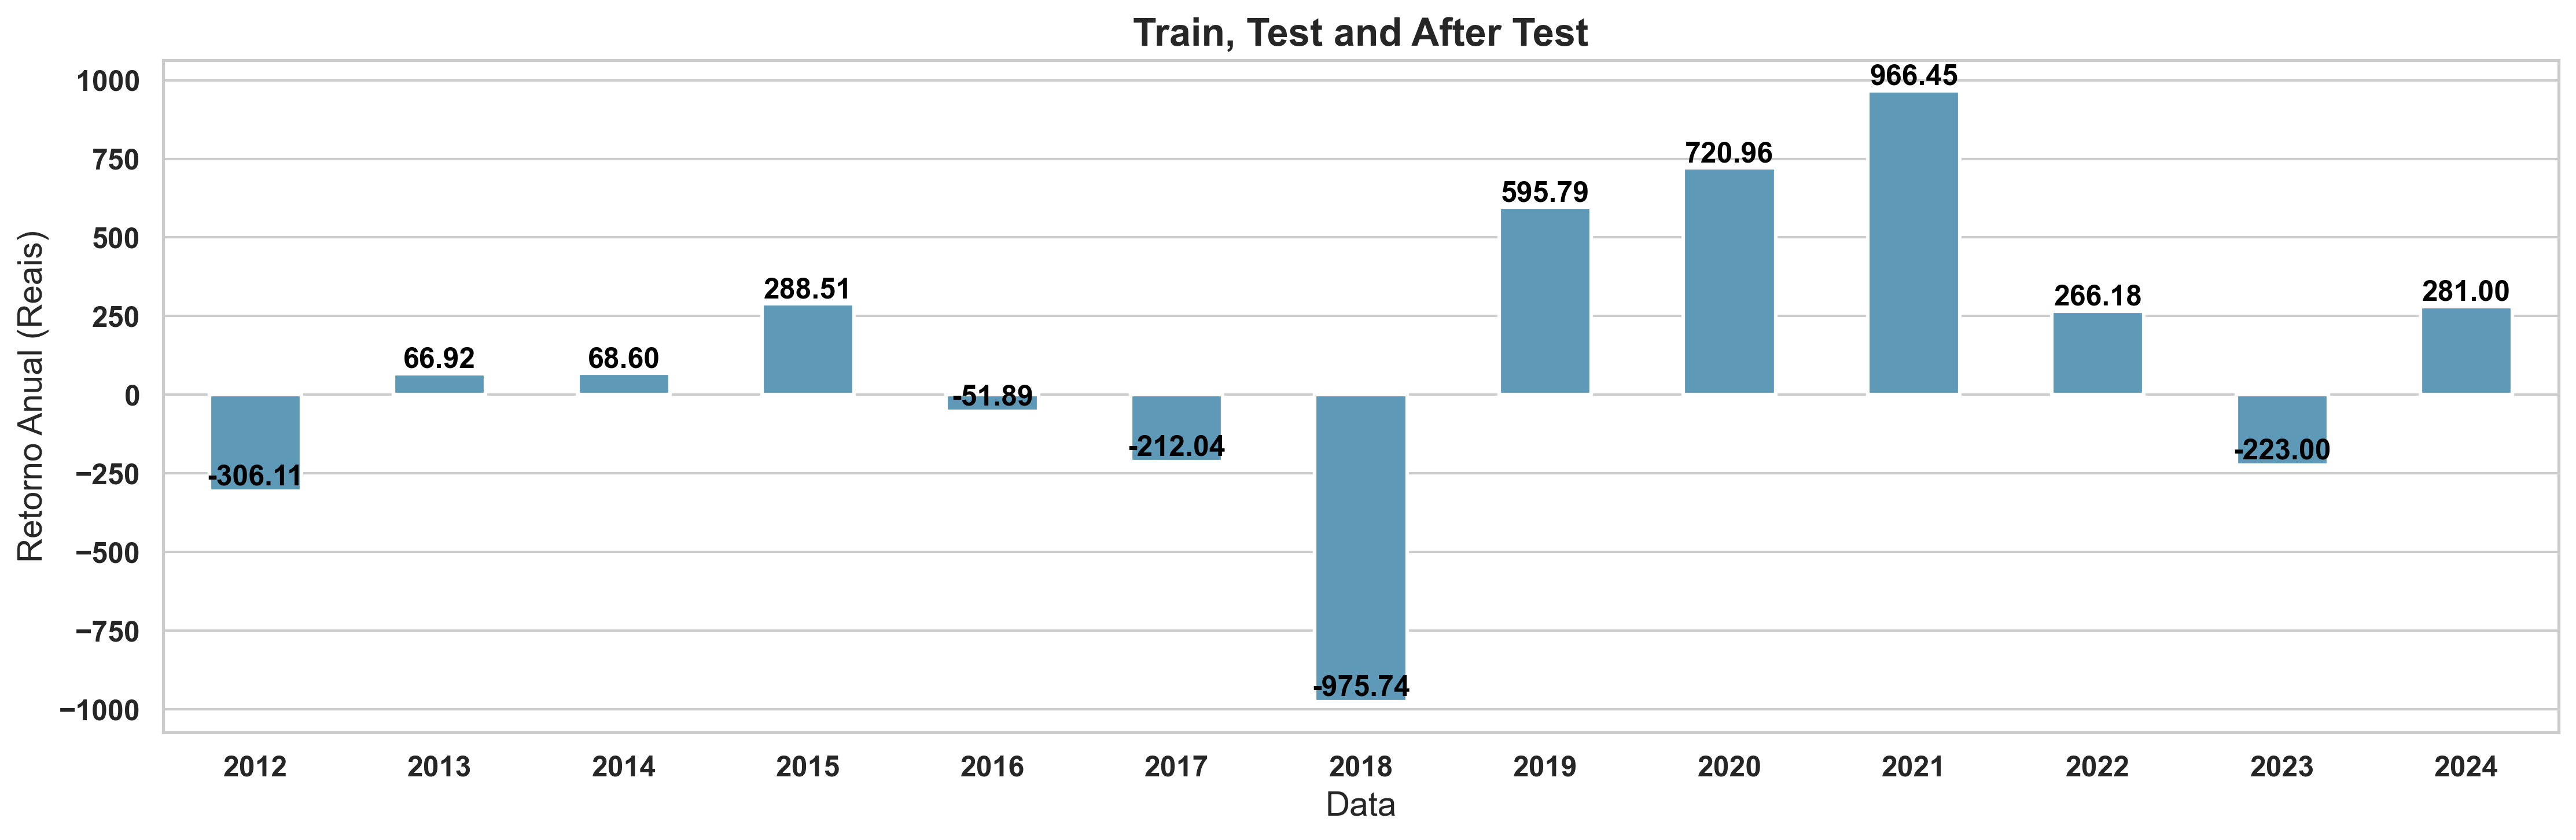

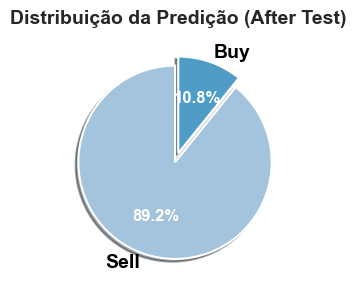

In [3]:
ot = None

for _ in range(1, 51):
    
    def __0__(df):
        """
        ticker = 'BBDC4.SA'
        start = '2012-05-11'
        end = '2022-05-11'
        """

        from numpy import sqrt

        volume = df['Volume']                                               
        adj_close = df['Adj Close'].pct_change(1)     
        close = df['Close']
        open = df['Open']            
        low = df['Low']     
        high = df['High']    

        _c = 6.371 
        _p = 3.14159265358979323846

        Q = lambda x, t=5: x.rolling(t).std()
        W = lambda x, t=5: x.rolling(t).sum()
        E = lambda x, t=5: x.rolling(t).mean()
        R = lambda x, t=5: x.rolling(t).median()
        T = lambda x, t=5: x.rolling(t).max()
        Y = lambda x, t=5: x.rolling(t).min()
        U = lambda x: x.diff().diff()
        I = lambda x: x - x.shift(1)
        O = lambda x: x * x.shift(1) * x.shift(2)
        
        q = lambda x, t=5: 1 / (1 - Q(x, t))

        a = I(E(q(high.diff(), 23) - q(low.diff(), 23), 8))
        s = Y(a) - ((O(a) * U(volume)) / (Q(adj_close) ** 2))
        
        return s


    _rswsx(lambda df: __0__(df), ot = ot, _=_)

    if ot is None:
        break
